<font color = blue><font size = 6> H(ALF)DLSTM </font></font><br>
결론적으로 LSTM은 seasonal에 주고 trend와 seasonal의 비율을 적당히 맞추는게 중요함<br>
&rightarrow; 이번에는 trend와 seasonal을 각각 scaling

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [95]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [96]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [97]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online_learning_seq2seq']

In [98]:
class Seasonal_Encoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [99]:
class Seasonal_Decoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [100]:
tup= (1,2)
len(tup)

2

In [101]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [102]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [103]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.device = torch.device('cuda:0')
        self.season_encoder = Seasonal_Encoder(configs)
        self.season_decoder = Seasonal_Decoder(configs)
        
        self.Linear_Trend = nn.Linear(1440,1)
        
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
#         div_factor = x[:,-1,:].view(-1,1,1)
#         x = x/div_factor
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1),trend_init.permute(0,2,1)
        season_factor,trend_factor = seasonal_init[:,-1,:].view(-1,1,1),trend_init[:,-1,:].view(-1,1,1)
        seasonal_init,trend_init = seasonal_init-season_factor, trend_init-trend_factor
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.permute(0,2,1).to(self.device) 

        _,final_season_hidden = self.season_encoder(seasonal_init)
        season_output,_ = self.season_decoder(x = seasonal_init[:,-1,:].view(-1,1,1),encoder_hidden = final_season_hidden)
        trend_output = self.Linear_Trend(trend_init)
        
        output = trend_output+trend_factor+season_output+season_factor
        
        return output,season_output,trend_output

In [104]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [105]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [106]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [107]:
target

tensor([[[22.0614]],

        [[22.0653]],

        [[22.0655]],

        ...,

        [[22.4421]],

        [[22.4284]],

        [[22.4296]]], device='cuda:0')

In [108]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-03.


In [109]:
torch.manual_seed(42)

In [110]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [111]:
out_list = []
loss_list = []
ss_list = []
tr_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out,ss,tr = model(seq)
#        print(out)
        loss = criterion(out,tg)
    
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        ss_list.append(ss)
        tr_list.append(tr)
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-04.
smape 2.9580335406047342 %
Adjusting learning rate of group 0 to 9.0250e-04.
smape 3.8944597983098324 %
Adjusting learning rate of group 0 to 8.5737e-04.
smape 3.4701787847521772 %
Adjusting learning rate of group 0 to 8.1451e-04.
smape 2.6185976554828896 %
Adjusting learning rate of group 0 to 7.7378e-04.
smape 3.0743417361045218 %
Adjusting learning rate of group 0 to 7.3509e-04.
smape 2.601949755399902 %
Adjusting learning rate of group 0 to 6.9834e-04.
smape 2.639697951415134 %
Adjusting learning rate of group 0 to 6.6342e-04.
smape 2.0136174619724097 %
Adjusting learning rate of group 0 to 6.3025e-04.
smape 2.5329581442580436 %
Adjusting learning rate of group 0 to 5.9874e-04.
smape 1.936804357608399 %
Adjusting learning rate of group 0 to 5.6880e-04.
smape 2.0102220173307 %
Adjusting learning rate of group 0 to 5.4036e-04.
smape 1.8567698424541097 %
Adjusting learning rate of group 0 to 5.1334e-04.
smape 1.887852112352113 %
Adjust

In [112]:
print(ss_list[26])
print(tr_list[0])

tensor([[[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]],

        [[0.1788]]], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([[[-0.1619]],

        [[-0.1626]],

        [[-0.1626]],

        [[-0.1622]],

        [[-0.1622]],

        [[-0.1615]],

        [[-0.1617]],

        [[-0.1621]],

        [[-0.1623]],

        [[-0.1629]],

        [[-0.1636]],

        [[-0.1638]],

        [[-0.1646]],



In [113]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out,_,_ = model(new_train) # 예측완료

        loss = criterion(out,tg)# 예측값과 타겟값의 비교

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out,_,_ = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.007975615581173656 %
SMAPE 0.005683322667863422 %
SMAPE 0.004063714095877913 %
SMAPE 0.006082506115490105 %
SMAPE 0.006880419910146429 %
SMAPE 0.008420227954417214 %
SMAPE 0.005102429069552272 %
SMAPE 0.0032901801100138073 %
SMAPE 0.0036297988569344857 %
SMAPE 0.004783546393781535 %
SMAPE 0.004478221922326497 %
SMAPE 0.0030774475588728483 %
SMAPE 0.007226353388006145 %
SMAPE 0.0029406249678842755 %
SMAPE 0.001877088197538512 %
SMAPE 0.014286600720282651 %
SMAPE 0.016386804303238023 %
SMAPE 0.014414693535151459 %
SMAPE 0.010539467034476502 %
SMAPE 0.0022337657927664623 %
SMAPE 0.008430363201213709 %
SMAPE 0.0010597691238984908 %
SMAPE 0.01707222791979035 %
SMAPE 0.0157205016549824 %
SMAPE 0.005150774526441637 %
SMAPE 0.01192163828234527 %
SMAPE 0.01352388921108627 %
SMAPE 0.012152063587137718 %
SMAPE 0.02084819312625541 %
SMAPE 0.02396158160516393 %
SMAPE 0.018128056712704677 %
SMAPE 0.004783367979939612 %
SMAPE 0.0042526217565637126 %
SMAPE 0.001704660694940685 %
SMAPE 0.003478

SMAPE 0.006435356170243266 %
SMAPE 0.012587356857920895 %
SMAPE 0.014831970007932682 %
SMAPE 0.046585784529298735 %
SMAPE 0.05065346675729643 %
SMAPE 0.005972057556213883 %
SMAPE 0.011197364626440276 %
SMAPE 0.010324528626995289 %
SMAPE 0.004410638716734638 %
SMAPE 0.0026672113959307353 %
SMAPE 0.006765354304270943 %
SMAPE 0.005855543894057291 %
SMAPE 0.005820231908444384 %
SMAPE 0.00719139144462133 %
SMAPE 0.007100329481886547 %
SMAPE 0.006967755594189384 %
SMAPE 0.005661758785208804 %
SMAPE 0.0026776070641858496 %
SMAPE 0.0011234734787137768 %
SMAPE 0.002240918334678099 %
SMAPE 0.0023771489115063105 %
SMAPE 0.003926760377567007 %
SMAPE 0.002945708931868296 %
SMAPE 0.0019523915692047922 %
SMAPE 0.006787255188555719 %
SMAPE 0.005636363284253321 %
SMAPE 0.0064095946514726165 %
SMAPE 0.01491765873164752 %
SMAPE 0.007304693084705605 %
SMAPE 0.0076924032550920165 %
SMAPE 0.005820394905136084 %
SMAPE 0.004804621189776981 %
SMAPE 0.003068430776586695 %
SMAPE 0.0238954843939041 %
SMAPE 0.0321

SMAPE 0.0052804854196182305 %
SMAPE 0.004973155090191028 %
SMAPE 0.0037370638155778124 %
SMAPE 0.0007849400873567447 %
SMAPE 0.0046337625452324005 %
SMAPE 0.010535571089633322 %
SMAPE 0.004416748149026262 %
SMAPE 0.0130243937213379 %
SMAPE 0.004582873448498503 %
SMAPE 0.001422122074473009 %
SMAPE 0.009615335884028298 %
SMAPE 0.006681790671791532 %
SMAPE 0.030495409239144067 %
SMAPE 0.01851176235652474 %
SMAPE 0.008817146305815982 %
SMAPE 0.003001188338174643 %
SMAPE 0.0015690039261144761 %
SMAPE 0.011026601262528857 %
SMAPE 0.0034967834314159067 %
SMAPE 0.0015429152924326672 %
SMAPE 0.002862651301597907 %
SMAPE 0.0027943755222636923 %
SMAPE 0.0045052408738257554 %
SMAPE 0.0037927765449978774 %
SMAPE 0.004175659932649012 %
SMAPE 0.003220797683354704 %
SMAPE 0.000681913436466175 %
SMAPE 0.0013110549077737232 %
SMAPE 0.011696287830318397 %
SMAPE 0.0018038822030064239 %
SMAPE 0.0017833405311975523 %
SMAPE 0.002032259332949593 %
SMAPE 0.00853218660188304 %
SMAPE 0.010417475498115891 %
SMAPE

SMAPE 0.0051123244862765205 %
SMAPE 0.014843204702565062 %
SMAPE 0.00901094519150547 %
SMAPE 0.005126380077740578 %
SMAPE 0.0014475669397171487 %
SMAPE 0.0012779799731958974 %
SMAPE 0.026003448083486095 %
SMAPE 0.015767194569598075 %
SMAPE 0.0065289721426893274 %
SMAPE 0.0014721568560673859 %
SMAPE 0.001600805787198567 %
SMAPE 0.00523919065954459 %
SMAPE 0.007110661175715904 %
SMAPE 0.004493740062855522 %
SMAPE 0.0020253516711079556 %
SMAPE 0.0011820670922020327 %
SMAPE 0.008162669799474997 %
SMAPE 0.0036754238951743896 %
SMAPE 0.004790891142960163 %
SMAPE 0.0034827977010536415 %
SMAPE 0.002623830847596764 %
SMAPE 0.0045661226258388865 %
SMAPE 0.006145629613456549 %
SMAPE 0.0010181803544355716 %
SMAPE 0.00918663751743054 %
SMAPE 0.003219188499997472 %
SMAPE 0.0014216279078027583 %
SMAPE 0.0016095184450222177 %
SMAPE 0.001409412233584817 %
SMAPE 0.0026485016983883725 %
SMAPE 0.0027483349147416902 %
SMAPE 0.006520358378907076 %
SMAPE 0.0026694432438603144 %
SMAPE 0.002664038310200567 %
S

SMAPE 0.0059437080517739105 %
SMAPE 0.0015109672974915611 %
SMAPE 0.007044516281666802 %
SMAPE 0.0004775413617892355 %
SMAPE 0.0030876759516260677 %
SMAPE 0.006632533195457314 %
SMAPE 0.011865001422876276 %
SMAPE 0.0029357400446770043 %
SMAPE 0.002185558428237755 %
SMAPE 0.001603682891342828 %
SMAPE 0.003935263788065413 %
SMAPE 0.0032557992886381726 %
SMAPE 0.008419636533574248 %
SMAPE 0.0022862024345329246 %
SMAPE 0.014065406015731696 %
SMAPE 0.007926651518886274 %
SMAPE 0.0007459640717826233 %
SMAPE 0.005817626696938305 %
SMAPE 0.008322413284531649 %
SMAPE 0.010562154233753063 %
SMAPE 0.0024045443588107673 %
SMAPE 0.01003141017142184 %
SMAPE 0.0065910536455930915 %
SMAPE 0.003190227822869929 %
SMAPE 0.003027804225396835 %
SMAPE 0.002735556331330713 %
SMAPE 0.0011746937391308165 %
SMAPE 0.005262941804105026 %
SMAPE 0.007324878729377814 %
SMAPE 0.00787650356528502 %
SMAPE 0.004984576521749773 %
SMAPE 0.002736984469379422 %
SMAPE 0.005625898825954323 %
SMAPE 0.004203749503219001 %
SMAPE

SMAPE 0.003826889701272762 %
SMAPE 0.003854150988161109 %
SMAPE 0.0015983413658062773 %
SMAPE 0.0008606668529864692 %
SMAPE 0.0023146523507833194 %
SMAPE 0.0026135420679338495 %
SMAPE 0.0033485493177352055 %
SMAPE 0.00495403958177576 %
SMAPE 0.011799417422878378 %
SMAPE 0.005226178123834302 %
SMAPE 0.0028812343149979824 %
SMAPE 0.001895813880651076 %
SMAPE 0.008535521339830154 %
SMAPE 0.006162662718907086 %
SMAPE 0.0024034554785430373 %
SMAPE 0.00211549405793221 %
SMAPE 0.010271352175934112 %
SMAPE 0.005132212338196496 %
SMAPE 0.0037285654199763485 %
SMAPE 0.010515607734078003 %
SMAPE 0.010449365152226164 %
SMAPE 0.007626794463021725 %
SMAPE 0.004887769107767781 %
SMAPE 0.0026434482763306733 %
SMAPE 0.0009911794763297621 %
SMAPE 0.001839649079883543 %
SMAPE 0.003508221099423281 %
SMAPE 0.0006889622984544985 %
SMAPE 0.0019474039389422162 %
SMAPE 0.00285523493795381 %
SMAPE 0.001060284320239191 %
SMAPE 0.008562723868365651 %
SMAPE 0.00707799977999457 %
SMAPE 0.0030130287845651083 %
SMAPE

SMAPE 0.0011876557567802593 %
SMAPE 0.007287587081151513 %
SMAPE 0.002850417294624208 %
SMAPE 0.0023512400992160565 %
SMAPE 0.0047374501711772155 %
SMAPE 0.0036023817221746413 %
SMAPE 0.0017143514445479013 %
SMAPE 0.002289981227079352 %
SMAPE 0.005698712213913382 %
SMAPE 0.0033323788425150265 %
SMAPE 0.0024300614874448456 %
SMAPE 0.0027660961140156815 %
SMAPE 0.003025012179278974 %
SMAPE 0.0044185527779063705 %
SMAPE 0.001960185903648437 %
SMAPE 0.006958818899647667 %
SMAPE 0.004239369652196956 %
SMAPE 0.003479961063590054 %
SMAPE 0.011238752502663374 %
SMAPE 0.0038679441675242283 %
SMAPE 0.003168622262876397 %
SMAPE 0.005242295983777012 %
SMAPE 0.002272521845270603 %
SMAPE 0.0030813479738753813 %
SMAPE 0.005291019308629075 %
SMAPE 0.0008885694844025239 %
SMAPE 0.005011834899050882 %
SMAPE 0.006070936068432786 %
SMAPE 0.0027028958438677364 %
SMAPE 0.006062644663430206 %
SMAPE 0.003359996905317075 %
SMAPE 0.001888874940561891 %
SMAPE 0.0048359426602360145 %
SMAPE 0.0017061413508088208 %

SMAPE 0.0020971726162173354 %
SMAPE 0.007086336384190872 %
SMAPE 0.008089675527145346 %
SMAPE 0.005413114904790461 %
SMAPE 0.001298923539820862 %
SMAPE 0.003174800221074747 %
SMAPE 0.0013918811383177854 %
SMAPE 0.0019676297352901884 %
SMAPE 0.0026968776191438337 %
SMAPE 0.0013884531299765968 %
SMAPE 0.00937760704185564 %
SMAPE 0.004518546151743408 %
SMAPE 0.002779604932101165 %
SMAPE 0.013540128427649734 %
SMAPE 0.01924879397646606 %
SMAPE 0.003796836415233429 %
SMAPE 0.004631719028623138 %
SMAPE 0.0047023439717577276 %
SMAPE 0.004585483958152281 %
SMAPE 0.003130622890935797 %
SMAPE 0.010653227062306314 %
SMAPE 0.008856328863657836 %
SMAPE 0.0007611083677971919 %
SMAPE 0.005479524168208627 %
SMAPE 0.0026287245905436407 %
SMAPE 0.004336801843692228 %
SMAPE 0.003581318842357461 %
SMAPE 0.0008456580268330072 %
SMAPE 0.0018128276416433664 %
SMAPE 0.0055280619880591075 %
SMAPE 0.005250242815172612 %
SMAPE 0.013018114007884662 %
SMAPE 0.016328738456536485 %
SMAPE 0.008853144042447525 %
SMAPE

SMAPE 0.0016045092819751972 %
SMAPE 0.0014696711807289375 %
SMAPE 0.0013104813199191767 %
SMAPE 0.005454930203200092 %
SMAPE 0.004860464801083708 %
SMAPE 0.006916745115447043 %
SMAPE 0.0023080789812865987 %
SMAPE 0.006194290048505024 %
SMAPE 0.0030983785605940284 %
SMAPE 0.0045328295006754615 %
SMAPE 0.0014709709516793623 %
SMAPE 0.0021352192809445114 %
SMAPE 0.0005426559145433885 %
SMAPE 0.0032749449476341397 %
SMAPE 0.0030189571099583645 %
SMAPE 0.00228090273934356 %
SMAPE 0.003358986807853626 %
SMAPE 0.004498200983363176 %
SMAPE 0.002838311213366751 %
SMAPE 0.005958187746273325 %
SMAPE 0.0020974083949596434 %
SMAPE 0.005874336238377964 %
SMAPE 0.007830183799569568 %
SMAPE 0.0018115059279750767 %
SMAPE 0.002322793117770061 %
SMAPE 0.0018461640806606283 %
SMAPE 0.003539627742213725 %
SMAPE 0.005502592547031782 %
SMAPE 0.0021920374529997844 %
SMAPE 0.0024222729144156574 %
SMAPE 0.004035734461965035 %
SMAPE 0.006303854731243064 %
SMAPE 0.002849987266500875 %
SMAPE 0.007349175774784555 %

SMAPE 0.010972273864666704 %
SMAPE 0.0012538185016097714 %
SMAPE 0.006099230998550809 %
SMAPE 0.0032699304872494395 %
SMAPE 0.000836894105290753 %
SMAPE 0.0011387769162638506 %
SMAPE 0.004613919914199016 %
SMAPE 0.01222044224016372 %
SMAPE 0.004578991793920295 %
SMAPE 0.0041977089379940935 %
SMAPE 0.0022409823005205 %
SMAPE 0.011714395038893599 %
SMAPE 0.005798003869045942 %
SMAPE 0.005386189652256235 %
SMAPE 0.0012049312098127984 %
SMAPE 0.004938203525028939 %
SMAPE 0.010514603403890987 %
SMAPE 0.008976566131508434 %
SMAPE 0.001038329887336431 %
SMAPE 0.005297911069902739 %
SMAPE 0.006183397582731231 %
SMAPE 0.009038221616236797 %
SMAPE 0.004144083230272599 %
SMAPE 0.003369628412343672 %
SMAPE 0.0031948286220710997 %
SMAPE 0.018200363473454217 %
SMAPE 0.0005864294771953382 %
SMAPE 0.01010219193713624 %
SMAPE 0.004210713522070364 %
SMAPE 0.0036054253761008685 %
SMAPE 0.0015840446096149208 %
SMAPE 0.004916584856488271 %
SMAPE 0.010422222558844396 %
SMAPE 0.0008840395560198999 %
SMAPE 0.

SMAPE 0.003325547147397856 %
SMAPE 0.0011086795809518435 %
SMAPE 0.00558790242760665 %
SMAPE 0.0008721751168820902 %
SMAPE 0.019308124842723373 %
SMAPE 0.008953157463267303 %
SMAPE 0.0024309319765336568 %
SMAPE 0.0008718875866975395 %
SMAPE 0.001669558774779034 %
SMAPE 0.004417621178085085 %
SMAPE 0.0012979815030575992 %
SMAPE 0.0027087798370502014 %
SMAPE 0.002370781348872697 %
SMAPE 0.0068868615963211255 %
SMAPE 0.0007105327228487113 %
SMAPE 0.00460077866326003 %
SMAPE 0.008972308670450957 %
SMAPE 0.0009448466084904793 %
SMAPE 0.0030085118862643867 %
SMAPE 0.004131833678030716 %
SMAPE 0.0027482346386733525 %
SMAPE 0.0028339434746982306 %
SMAPE 0.005119273387840906 %
SMAPE 0.0019748764687363973 %
SMAPE 0.001037791116843323 %
SMAPE 0.002552145517398685 %
SMAPE 0.0029057393376206164 %
SMAPE 0.008219571105428258 %
SMAPE 0.0008906121152989499 %
SMAPE 0.0013406776580779933 %
SMAPE 0.0023928631449052773 %
SMAPE 0.006951116230624166 %
SMAPE 0.00498838547853353 %
SMAPE 8.580185778439045 %
SMA

SMAPE 0.014228216377887293 %
SMAPE 0.005668586345642268 %
SMAPE 0.009967686674912102 %
SMAPE 0.008901548544841376 %
SMAPE 0.003586352031376805 %
SMAPE 0.004395640911184273 %
SMAPE 0.002292356072075563 %
SMAPE 0.003982551961229319 %
SMAPE 0.007129878453959293 %
SMAPE 0.00884567213694254 %
SMAPE 0.012279562754542893 %
SMAPE 0.0021970851037949046 %
SMAPE 0.0037938215188049185 %
SMAPE 0.011674456141577139 %
SMAPE 0.011684580361531971 %
SMAPE 0.006431980448269314 %
SMAPE 0.004868443109103282 %
SMAPE 0.0022614577625859056 %
SMAPE 0.020184369352932663 %
SMAPE 0.0035714914029014726 %
SMAPE 0.014896396496226318 %
SMAPE 0.015860384987092857 %
SMAPE 0.0018175921789875815 %
SMAPE 0.021446332170171445 %
SMAPE 0.011603258894410828 %
SMAPE 0.0037259024067566315 %
SMAPE 0.0056019461312644125 %
SMAPE 0.0027296109432484172 %
SMAPE 0.00278413047885806 %
SMAPE 0.0019062305384522915 %
SMAPE 0.010563084344255458 %
SMAPE 0.017748507181039486 %
SMAPE 0.0028641930198318732 %
SMAPE 0.00509465147288779 %
SMAPE 0

SMAPE 0.019966817181853003 %
SMAPE 0.006027281050961619 %
SMAPE 0.014876368246206084 %
SMAPE 0.016288431818395566 %
SMAPE 0.018183285569648433 %
SMAPE 0.003039472777913943 %
SMAPE 0.007416463908697323 %
SMAPE 0.0018069070730746262 %
SMAPE 0.019579628576934738 %
SMAPE 0.010691688473784211 %
SMAPE 0.004190555429829601 %
SMAPE 0.032826144030423166 %
SMAPE 0.0007735787410183548 %
SMAPE 0.0034394970104472127 %
SMAPE 0.0010952160935673305 %
SMAPE 0.001705789997913598 %
SMAPE 0.006059272355997791 %
SMAPE 0.01602861566525604 %
SMAPE 0.005766132230569099 %
SMAPE 0.008216119947832112 %
SMAPE 0.013105394069839349 %
SMAPE 0.004195359704397106 %
SMAPE 0.0025377136303319503 %
SMAPE 0.004493043580822587 %
SMAPE 0.001740700113316507 %
SMAPE 0.00506866038065823 %
SMAPE 0.015461306405583741 %
SMAPE 0.006926558974221564 %
SMAPE 0.0020827540050163407 %
SMAPE 0.008405102991048352 %
SMAPE 0.001666753180813885 %
SMAPE 0.0038640052890173138 %
SMAPE 0.02231621034967901 %
SMAPE 0.0031881794609489593 %
SMAPE 0.0

SMAPE 0.006777958033779896 %
SMAPE 0.007832474295554448 %
SMAPE 0.010834449094929255 %
SMAPE 0.004369280623450322 %
SMAPE 0.004956946468041679 %
SMAPE 0.005318243776457621 %
SMAPE 0.0021275379870431266 %
SMAPE 0.00364538693283123 %
SMAPE 0.0008305021495971232 %
SMAPE 0.03378755496302688 %
SMAPE 0.03633841972037999 %
SMAPE 0.004045243663426845 %
SMAPE 0.005027533249887028 %
SMAPE 0.005581534344742067 %
SMAPE 0.008449294357717463 %
SMAPE 0.006089513851179618 %
SMAPE 0.011639793770427787 %
SMAPE 0.0024748425040854727 %
SMAPE 0.008727182455459115 %
SMAPE 0.009914955780971013 %
SMAPE 0.004774957526365142 %
SMAPE 0.01264920499750133 %
SMAPE 0.004091757522303396 %
SMAPE 0.005112576577943173 %
SMAPE 0.005916325769113939 %
SMAPE 0.0017232930746331474 %
SMAPE 0.02145740358855619 %
SMAPE 0.016355638366675862 %
SMAPE 0.009945013945525716 %
SMAPE 0.009171428860113906 %
SMAPE 0.006926945060911294 %
SMAPE 0.0019252210441038644 %
SMAPE 0.009907496042146136 %
SMAPE 0.0039377898548877965 %
SMAPE 0.00268

SMAPE 0.012501502769509898 %
SMAPE 0.006157412200138879 %
SMAPE 0.009328276762488485 %
SMAPE 0.009724281656076528 %
SMAPE 0.008592669264544384 %
SMAPE 0.0047487072037029066 %
SMAPE 0.007190543137255645 %
SMAPE 0.011263927652635175 %
SMAPE 0.015669513947187852 %
SMAPE 0.0016520867443432508 %
SMAPE 0.006806453692263403 %
SMAPE 0.003557699201678588 %
SMAPE 0.011522668487486953 %
SMAPE 0.0061032176557205275 %
SMAPE 0.01045260800270853 %
SMAPE 0.01905548034297766 %
SMAPE 0.02103674656387966 %
SMAPE 0.007299031114598619 %
SMAPE 0.006675456420538239 %
SMAPE 0.002500566882986277 %
SMAPE 0.001258622642914986 %
SMAPE 0.0027758510297530847 %
SMAPE 0.009934980555939887 %
SMAPE 0.0026200182291233887 %
SMAPE 0.001427148044861326 %
SMAPE 0.003122122896911605 %
SMAPE 0.009305856345918073 %
SMAPE 0.0027058006289735204 %
SMAPE 0.015608881810948107 %
SMAPE 0.0027262492519639636 %
SMAPE 0.0026391066655406803 %
SMAPE 0.04098201809938473 %
SMAPE 0.0022168876609214294 %
SMAPE 0.005362134681377029 %
SMAPE 0.0

SMAPE 0.004024425777870988 %
SMAPE 0.006505078240735429 %
SMAPE 0.01934889382903293 %
SMAPE 0.003001186998304206 %
SMAPE 0.004285617110383555 %
SMAPE 0.0033316170222974506 %
SMAPE 0.012935288279237511 %
SMAPE 0.006162822880170893 %
SMAPE 0.0021807415945716002 %
SMAPE 0.0023811148138861427 %
SMAPE 0.010070912807506716 %
SMAPE 0.039987192517543235 %
SMAPE 0.01442756377321075 %
SMAPE 0.002403599244786392 %
SMAPE 0.002029394016972219 %
SMAPE 0.010091621717947419 %
SMAPE 0.0069056996869107925 %
SMAPE 0.0037935762013603385 %
SMAPE 0.007723154561404044 %
SMAPE 0.001348877761202516 %
SMAPE 0.0016503243909937737 %
SMAPE 0.004833537249595565 %
SMAPE 0.00514924970912034 %
SMAPE 0.0013736102595061084 %
SMAPE 0.002688935330652953 %
SMAPE 0.001870539627901735 %
SMAPE 0.0055762204287646 %
SMAPE 0.0066154413176775515 %
SMAPE 0.004113309964466794 %
SMAPE 0.01610907855856425 %
SMAPE 0.002542049361181853 %
SMAPE 0.002722945398460297 %
SMAPE 0.009724840769194998 %
SMAPE 0.011327586110581933 %
SMAPE 0.0267

SMAPE 0.0019692203682382114 %
SMAPE 0.003653063356054531 %
SMAPE 0.008240097805156665 %
SMAPE 0.0070488633749334895 %
SMAPE 0.0020584298240464705 %
SMAPE 0.0031461208715910516 %
SMAPE 0.005701337206971857 %
SMAPE 0.007151703647785723 %
SMAPE 0.0264684043282557 %
SMAPE 0.00513403855109118 %
SMAPE 0.01191461043504205 %
SMAPE 0.00519792853663148 %
SMAPE 0.01846798238833003 %
SMAPE 0.009570683251034495 %
SMAPE 0.017010584415629637 %
SMAPE 0.003865961362123471 %
SMAPE 0.01849961312831283 %
SMAPE 0.0049493337488115685 %
SMAPE 0.010433820529371474 %
SMAPE 0.003953497112917148 %
SMAPE 0.006795449716719304 %
SMAPE 0.002614399595273653 %
SMAPE 0.004702393982881858 %
SMAPE 0.007345205803630961 %
SMAPE 0.0018018862421200763 %
SMAPE 0.0012691874394477054 %
SMAPE 0.0057027544307288736 %
SMAPE 0.008629758251515796 %
SMAPE 0.003364792731616717 %
SMAPE 0.0029536137633385806 %
SMAPE 0.0041386125883207114 %
SMAPE 0.0010894363354907455 %
SMAPE 0.0019323431870930108 %
SMAPE 0.002388287994875782 %
SMAPE 0.0

SMAPE 0.07160543092390981 %
SMAPE 0.0016379468596028348 %
SMAPE 0.0041964956353695015 %
SMAPE 0.0044305450934132296 %
SMAPE 0.031324594307534426 %
SMAPE 0.03242486481093465 %
SMAPE 0.07420081166901582 %
SMAPE 0.0018596331086087046 %
SMAPE 0.014830302731411393 %
SMAPE 0.004812940678675659 %
SMAPE 0.04367901254393303 %
SMAPE 0.036134102682410685 %
SMAPE 0.11647835561092279 %
SMAPE 0.04747030438738875 %
SMAPE 0.024255933155416187 %
SMAPE 0.009897132160176625 %
SMAPE 0.022552276329278698 %
SMAPE 0.012189050189647332 %
SMAPE 0.017191425074997824 %
SMAPE 0.003967071427979363 %
SMAPE 0.0028503745947929815 %
SMAPE 0.01432178269152473 %
SMAPE 0.03874898892638612 %
SMAPE 0.025421055004699156 %
SMAPE 0.02778738352719756 %
SMAPE 0.021642743397841002 %
SMAPE 0.0027341823173969715 %
SMAPE 0.009628786463551364 %
SMAPE 0.040069985188438295 %
SMAPE 0.045910401417359026 %
SMAPE 0.013492762362830035 %
SMAPE 0.0035802170785927956 %
SMAPE 0.00889654964453257 %
SMAPE 0.012359490459203926 %
SMAPE 0.005423078

SMAPE 0.05613844136610169 %
SMAPE 0.11838480694564169 %
SMAPE 0.030568668561450355 %
SMAPE 0.2498952145826934 %
SMAPE 0.11023169923851128 %
SMAPE 0.27693989326098745 %
SMAPE 1.0366065783891827 %
SMAPE 0.8979206970361703 %
SMAPE 0.0258946615265927 %
SMAPE 0.0019715035589342733 %
SMAPE 0.24189658410398354 %
SMAPE 0.37176468968846166 %
SMAPE 0.23138815105858157 %
SMAPE 0.09574461347585839 %
SMAPE 0.14449606832340578 %
SMAPE 0.2081994569766721 %
SMAPE 0.009021457616427142 %
SMAPE 0.2070861099789454 %
SMAPE 0.09673780323555548 %
SMAPE 0.25703008760365265 %
SMAPE 0.10643831179174866 %
SMAPE 0.009717456714504635 %
SMAPE 0.14604435641467717 %
SMAPE 0.14994766338145382 %
SMAPE 0.03469231204957168 %
SMAPE 0.19298792632406503 %
SMAPE 0.018136800193701674 %
SMAPE 0.08442323425106224 %
SMAPE 0.05864244587053236 %
SMAPE 0.03194230712107071 %
SMAPE 0.13717407596969622 %
SMAPE 0.2107168606653431 %
SMAPE 0.10710279596071359 %
SMAPE 0.06893059893513964 %
SMAPE 0.016048463801553225 %
SMAPE 0.213415678377

SMAPE 0.01228478949583689 %
SMAPE 0.003827466169958882 %
SMAPE 0.0041139980752973315 %
SMAPE 0.011858004564864189 %
SMAPE 0.013975199516387702 %
SMAPE 0.005969791176369199 %
SMAPE 0.02263646826582999 %
SMAPE 0.010839176243003124 %
SMAPE 0.0017762090728012936 %
SMAPE 0.013460766167554537 %
SMAPE 0.020274568033812557 %
SMAPE 0.011906580586128257 %
SMAPE 0.04057928136188593 %
SMAPE 0.0012407982744946366 %
SMAPE 0.01809868628396316 %
SMAPE 0.04240113325667494 %
SMAPE 0.03398540057543187 %
SMAPE 0.028238911255272114 %
SMAPE 0.008340732633200787 %
SMAPE 0.007269650603348055 %
SMAPE 0.03819013954191064 %
SMAPE 0.023817728971550878 %
SMAPE 0.007305992854725218 %
SMAPE 0.004237623364488741 %
SMAPE 0.0011720521911229298 %
SMAPE 0.04872973055287133 %
SMAPE 0.07323915809274695 %
SMAPE 0.018314548272826414 %
SMAPE 0.0030172540308512907 %
SMAPE 0.01684637266209421 %
SMAPE 0.0073974681040454016 %
SMAPE 0.05593099518318923 %
SMAPE 0.013157761548143299 %
SMAPE 0.020370086350986583 %
SMAPE 0.03580748979

SMAPE 0.035243555412897365 %
SMAPE 0.006406141315736136 %
SMAPE 0.01967516118778434 %
SMAPE 0.008831554003521092 %
SMAPE 0.003746051364686309 %
SMAPE 0.15664948830562508 %
SMAPE 0.008082315186811684 %
SMAPE 0.03920218106691209 %
SMAPE 0.03526763827581192 %
SMAPE 0.016062195565226034 %
SMAPE 0.034270072233539395 %
SMAPE 0.06295373348956446 %
SMAPE 0.0018783358157747898 %
SMAPE 0.017894611836055674 %
SMAPE 0.001601084497337979 %
SMAPE 0.006581316023698491 %
SMAPE 0.006769468640897004 %
SMAPE 0.01130898744086295 %
SMAPE 0.009426527135474316 %
SMAPE 0.0055566308939205555 %
SMAPE 0.021379854113661168 %
SMAPE 0.0027296620096066704 %
SMAPE 0.0014095209633993022 %
SMAPE 0.011798045475046592 %
SMAPE 0.03221646171368775 %
SMAPE 0.013755377602990395 %
SMAPE 0.006520437025187676 %
SMAPE 0.003841157596468747 %
SMAPE 0.05777790872238597 %
SMAPE 0.009668029796245037 %
SMAPE 0.005339499585204521 %
SMAPE 0.0015599357933666624 %
SMAPE 0.004063093192485212 %
SMAPE 0.024376657778390154 %
SMAPE 0.043349738

SMAPE 0.013020944706582327 %
SMAPE 0.0195512019851094 %
SMAPE 0.013181407759475407 %
SMAPE 0.016070090855521357 %
SMAPE 0.0032116155918586737 %
SMAPE 0.017395110538586778 %
SMAPE 0.007281873769045433 %
SMAPE 0.008151163190007082 %
SMAPE 0.031016068998567903 %
SMAPE 0.013296897755481043 %
SMAPE 0.013881686692911899 %
SMAPE 0.011217371875602566 %
SMAPE 0.00947000970174372 %
SMAPE 0.045001737933006325 %
SMAPE 0.0028992509832050928 %
SMAPE 0.011307334480605391 %
SMAPE 0.007938859788623631 %
SMAPE 0.004603671025265044 %
SMAPE 0.05318806894956652 %
SMAPE 0.0037455589250896537 %
SMAPE 0.02131786741074393 %
SMAPE 0.003339720024058579 %
SMAPE 0.03647294654962252 %
SMAPE 0.03281844758795671 %
SMAPE 0.014014163262089598 %
SMAPE 0.010518055288628148 %
SMAPE 0.011387620419498035 %
SMAPE 0.031525186124184756 %
SMAPE 0.016861993949504495 %
SMAPE 0.03274149890731337 %
SMAPE 0.01896806058925904 %
SMAPE 0.016215104013213022 %
SMAPE 0.0017812738775688786 %
SMAPE 0.00743105023411772 %
SMAPE 0.014071938608

SMAPE 0.16478931571927546 %
SMAPE 0.004791965097084017 %
SMAPE 0.07317711732139287 %
SMAPE 0.007083377669118818 %
SMAPE 0.04217172480775844 %
SMAPE 0.13352376838810187 %
SMAPE 0.20133306340449053 %
SMAPE 0.033594621565470106 %
SMAPE 0.06216803399729542 %
SMAPE 0.009690883733014743 %
SMAPE 0.05638357295242714 %
SMAPE 0.19128277219897427 %
SMAPE 0.04905252684528705 %
SMAPE 0.056255490059115225 %
SMAPE 0.014974359547615279 %
SMAPE 0.009465067457981036 %
SMAPE 0.0013618072407979298 %
SMAPE 0.03809007139459197 %
SMAPE 0.037093481511874415 %
SMAPE 0.006798103030348556 %
SMAPE 0.009980020976882997 %
SMAPE 0.004886306124149087 %
SMAPE 0.027730244933195536 %
SMAPE 0.008675748378834669 %
SMAPE 0.09815259494689599 %
SMAPE 0.005505241466153166 %
SMAPE 0.007736828336135204 %
SMAPE 0.007238197359043852 %
SMAPE 0.028161711173197546 %
SMAPE 0.009493835195854672 %
SMAPE 0.06628025546464755 %
SMAPE 0.003154516791937567 %
SMAPE 0.0016272464413873422 %
SMAPE 0.02650109421279012 %
SMAPE 0.02347771341999305

SMAPE 0.0010712781158730422 %
SMAPE 0.02758194537500458 %
SMAPE 0.00654409283310997 %
SMAPE 0.005019170413191887 %
SMAPE 0.023826230749428134 %
SMAPE 0.017772653574709807 %
SMAPE 0.0024765469259051542 %
SMAPE 0.014235537103502338 %
SMAPE 0.0012457723559293754 %
SMAPE 0.0011732307320926338 %
SMAPE 0.009628026534642231 %
SMAPE 0.04639372277182474 %
SMAPE 0.004537176048046376 %
SMAPE 0.025742646353855037 %
SMAPE 0.030963787537530152 %
SMAPE 0.04707992421299423 %
SMAPE 0.011250541203452258 %
SMAPE 0.011313763800714582 %
SMAPE 0.004707075108740355 %
SMAPE 0.011103466719703192 %
SMAPE 0.0067396785295841255 %
SMAPE 0.014707001165646714 %
SMAPE 0.01996051151442657 %
SMAPE 0.0034533588234353374 %
SMAPE 0.009341616639957806 %
SMAPE 0.029791696907636833 %
SMAPE 0.006365751276533161 %
SMAPE 0.02676255514987247 %
SMAPE 0.008166053469665258 %
SMAPE 0.012945619771130621 %
SMAPE 0.0040488077517863985 %
SMAPE 0.03403366413488129 %
SMAPE 0.008424674794738962 %
SMAPE 0.02452780730880022 %
SMAPE 0.0137225

SMAPE 0.006292191059969809 %
SMAPE 0.012810240599606004 %
SMAPE 0.003318084506091168 %
SMAPE 0.0038577704557667403 %
SMAPE 0.0037812980360740767 %
SMAPE 0.0016436800672465777 %
SMAPE 0.001971913610560705 %
SMAPE 0.0014961781619575731 %
SMAPE 0.00045461769587973316 %
SMAPE 0.001221607516953327 %
SMAPE 0.006458735671607485 %
SMAPE 0.008509171994454334 %
SMAPE 0.008709159951692413 %
SMAPE 0.02293169837913922 %
SMAPE 0.015606766207881151 %
SMAPE 0.005583130012865922 %
SMAPE 0.005702512029294837 %
SMAPE 0.0257108450529131 %
SMAPE 0.02505890217042861 %
SMAPE 0.023616391113982615 %
SMAPE 0.0008897760376171959 %
SMAPE 0.0019296938635164906 %
SMAPE 0.01982005031436529 %
SMAPE 0.00962151823921431 %
SMAPE 0.0054884345282886216 %
SMAPE 0.0030986167990008084 %
SMAPE 0.021147932797703106 %
SMAPE 0.022691723112416184 %
SMAPE 0.0313748612412752 %
SMAPE 0.027015801760512662 %
SMAPE 0.001996466585829637 %
SMAPE 0.004794877976053158 %
SMAPE 0.01744184020628836 %
SMAPE 0.008302550241253925 %
SMAPE 0.01655

SMAPE 0.002428694821787758 %
SMAPE 0.03570427278454247 %
SMAPE 0.0013710351203854998 %
SMAPE 0.0650773504286235 %
SMAPE 0.06577273595519273 %
SMAPE 0.04671363993043087 %
SMAPE 0.02335277619539511 %
SMAPE 0.04751323371903027 %
SMAPE 0.015895519011678516 %
SMAPE 0.0279677223542194 %
SMAPE 0.014191530324595192 %
SMAPE 0.0032677620986305556 %
SMAPE 0.04129236791385438 %
SMAPE 0.00605198644916527 %
SMAPE 0.04322085164830014 %
SMAPE 0.009915126292639798 %
SMAPE 0.008930938817755418 %
SMAPE 0.031133783814652816 %
SMAPE 0.01185273046341706 %
SMAPE 0.0006021772933877401 %
SMAPE 0.0018739274873098564 %
SMAPE 0.005913007085354138 %
SMAPE 0.01069638064494427 %
SMAPE 0.011934202316069786 %
SMAPE 0.0037470250665876392 %
SMAPE 0.003970651370622136 %
SMAPE 0.005333838826715009 %
SMAPE 0.006001740150921364 %
SMAPE 0.00956402671162948 %
SMAPE 0.0024545032373524123 %
SMAPE 0.012598677681552317 %
SMAPE 0.001185450668856447 %
SMAPE 0.008943659323556119 %
SMAPE 0.005423977744612785 %
SMAPE 0.009516717410122

SMAPE 0.005817834082435525 %
SMAPE 0.0104091246249709 %
SMAPE 0.0032037345223727694 %
SMAPE 0.014117377949943943 %
SMAPE 0.0013771962956639072 %
SMAPE 0.011443348462762515 %
SMAPE 0.0012911969604374463 %
SMAPE 0.0014875801073230832 %
SMAPE 0.02120285007558209 %
SMAPE 0.010982684726819514 %
SMAPE 0.003480003110524876 %
SMAPE 0.009673997917808208 %
SMAPE 0.003700526370735702 %
SMAPE 0.017187029093577166 %
SMAPE 0.011057966787909379 %
SMAPE 0.018544046794744418 %
SMAPE 0.028225761471361466 %
SMAPE 0.02267942760920505 %
SMAPE 0.021302031546838407 %
SMAPE 0.0006094745625873088 %
SMAPE 0.01263997613847323 %
SMAPE 0.00430228308231051 %
SMAPE 0.0032738494350255114 %
SMAPE 0.025257112858923847 %
SMAPE 0.01151377739105186 %
SMAPE 0.03985768255401467 %
SMAPE 0.019098536483738826 %
SMAPE 0.004443865635515465 %
SMAPE 0.006062439575742928 %
SMAPE 0.018519200869036467 %
SMAPE 0.002500417792504095 %
SMAPE 0.02257292316261328 %
SMAPE 0.011750763109503737 %
SMAPE 0.011321993835736066 %
SMAPE 0.004212309

SMAPE 0.0040203509549883165 %
SMAPE 0.00478171254951576 %
SMAPE 0.001646376825966911 %
SMAPE 0.0019795956970369843 %
SMAPE 0.005930320476863926 %
SMAPE 0.0012444081830977893 %
SMAPE 0.0009273702011682873 %
SMAPE 0.010957764328168196 %
SMAPE 0.007083048139165271 %
SMAPE 0.0016240096071555856 %
SMAPE 0.00937964788381862 %
SMAPE 0.0014819660022240555 %
SMAPE 0.003287669383482239 %
SMAPE 0.000676867680738269 %
SMAPE 0.008260464512162002 %
SMAPE 0.001995688750412228 %
SMAPE 0.005186559317337469 %
SMAPE 0.0080442460256549 %
SMAPE 0.0012750288442688884 %
SMAPE 0.003744939958068016 %
SMAPE 0.006508423638138083 %
SMAPE 0.0022152133185571188 %
SMAPE 0.009077820422533023 %
SMAPE 0.0010725156658395463 %
SMAPE 0.006802567299303063 %
SMAPE 0.0022839530817293507 %
SMAPE 0.0031548461015518114 %
SMAPE 0.0018640678938126596 %
SMAPE 0.004770609203944787 %
SMAPE 0.0009362112561959179 %
SMAPE 0.004723788146513641 %
SMAPE 0.015015225572568625 %
SMAPE 0.00613575844386105 %
SMAPE 0.00606161238256675 %
SMAPE 0

SMAPE 0.0050726565021648184 %
SMAPE 0.01713439269013861 %
SMAPE 0.004061048247962162 %
SMAPE 0.00041166691350724705 %
SMAPE 0.005706217899444255 %
SMAPE 0.003257117169319202 %
SMAPE 0.0009124621421392476 %
SMAPE 0.0007092435928228724 %
SMAPE 0.004052992551066836 %
SMAPE 0.0015520709747534056 %
SMAPE 0.004532570990647855 %
SMAPE 0.0015747061573847532 %
SMAPE 0.004346744588943352 %
SMAPE 0.005269502088069089 %
SMAPE 0.009141720919345175 %
SMAPE 0.004086974085126371 %
SMAPE 0.0011430865390877898 %
SMAPE 0.010972274557957462 %
SMAPE 0.002976681723339425 %
SMAPE 0.004900561218022403 %
SMAPE 0.00782847276832399 %
SMAPE 0.004004529039519866 %
SMAPE 0.003986901235379037 %
SMAPE 0.0023624352817677163 %
SMAPE 0.0011874769154331943 %
SMAPE 0.002891333886019254 %
SMAPE 0.0028845743464529505 %
SMAPE 0.004594507597225572 %
SMAPE 0.005780234342296353 %
SMAPE 0.01949704197079427 %
SMAPE 0.0026743534532229774 %
SMAPE 0.007645261462727149 %
SMAPE 0.003187289642767155 %
SMAPE 0.003936241216308645 %
SMAPE

SMAPE 0.002165821015523761 %
SMAPE 0.004180370420939994 %
SMAPE 0.01197477054375895 %
SMAPE 0.0034870680080061334 %
SMAPE 0.005355677236991596 %
SMAPE 0.005907897022382258 %
SMAPE 0.0036550726125739175 %
SMAPE 0.0006544394162872891 %
SMAPE 0.006405696691487606 %
SMAPE 0.00048089987011223917 %
SMAPE 0.004547997863546982 %
SMAPE 0.005341801814005009 %
SMAPE 0.008287291718822587 %
SMAPE 0.010281145227509114 %
SMAPE 0.0018103254503785138 %
SMAPE 0.005701793339980554 %
SMAPE 0.0013788736397941648 %
SMAPE 0.004015751548308799 %
SMAPE 0.003334971173046597 %
SMAPE 0.004190018233558135 %
SMAPE 0.005883234205946053 %
SMAPE 0.004927554516882537 %
SMAPE 0.006947089111676519 %
SMAPE 0.000572841137739033 %
SMAPE 0.0026033452225320275 %
SMAPE 0.002203396435675131 %
SMAPE 0.0072636334585354225 %
SMAPE 0.0038695418734420173 %
SMAPE 0.007260072513872728 %
SMAPE 0.003884883476871437 %
SMAPE 0.007190855542617669 %
SMAPE 0.0005417588621128289 %
SMAPE 0.003275584436977397 %
SMAPE 0.0031085642601738073 %
SMA

SMAPE 0.012466301135987122 %
SMAPE 0.0011615114964627082 %
SMAPE 0.0009912979732717986 %
SMAPE 0.0007806296197543361 %
SMAPE 0.001203709950338805 %
SMAPE 0.0023704562229127646 %
SMAPE 0.0012521564808025687 %
SMAPE 0.0013997813986819096 %
SMAPE 0.0055814688491153674 %
SMAPE 0.0007458131768771636 %
SMAPE 0.007983907116333455 %
SMAPE 0.004561076292873167 %
SMAPE 0.0019366293017242242 %
SMAPE 0.00035155122846930453 %
SMAPE 0.0035871587672744454 %
SMAPE 0.0124070445907023 %
SMAPE 0.006113351116823651 %
SMAPE 0.0014606582435732207 %
SMAPE 0.00120677951667858 %
SMAPE 0.0028063462763086022 %
SMAPE 0.003109582525368637 %
SMAPE 0.00721735505567267 %
SMAPE 0.0009305471562157662 %
SMAPE 0.001290232379290046 %
SMAPE 0.0010048013407271128 %
SMAPE 0.0018800737199171635 %
SMAPE 0.000844972751934847 %
SMAPE 0.0008653444014612433 %
SMAPE 0.0066179130080286095 %
SMAPE 0.0020483244912270493 %
SMAPE 0.001725482520043897 %
SMAPE 0.0020932500371770857 %
SMAPE 0.0014478501234549412 %
SMAPE 0.00415762227970617

SMAPE 0.005059738856459717 %
SMAPE 0.005567005942126002 %
SMAPE 0.004267988358407138 %
SMAPE 0.006738629529223772 %
SMAPE 0.010030188202222234 %
SMAPE 0.01663302605732042 %
SMAPE 0.002661063797127383 %
SMAPE 0.010502446603751991 %
SMAPE 0.003186985914680918 %
SMAPE 0.0021151437133326567 %
SMAPE 0.005342756930758696 %
SMAPE 0.005252514340519099 %
SMAPE 0.005486007309968954 %
SMAPE 0.0009666789725102375 %
SMAPE 0.00549840204365637 %
SMAPE 0.015168347879153998 %
SMAPE 0.017959192276897795 %
SMAPE 0.005458240050458585 %
SMAPE 0.0005993573036562339 %
SMAPE 0.0036328497130426736 %
SMAPE 0.0014572525181222318 %
SMAPE 0.0025418132250933922 %
SMAPE 0.003833622402567016 %
SMAPE 0.004256030648093656 %
SMAPE 0.0037896319914167975 %
SMAPE 0.002417072839890011 %
SMAPE 0.007783806242798619 %
SMAPE 0.0036138351568979488 %
SMAPE 0.002534394750377089 %
SMAPE 0.00113037576034003 %
SMAPE 0.006830752457219091 %
SMAPE 0.002576213375448333 %
SMAPE 0.0017789691951719533 %
SMAPE 0.004347885095739912 %
SMAPE 0.

SMAPE 0.0022072403096018434 %
SMAPE 0.0058286497879294075 %
SMAPE 0.0014043377098005294 %
SMAPE 0.00519826754802466 %
SMAPE 0.0045832304831492365 %
SMAPE 0.0008408764014049552 %
SMAPE 0.008016773640314057 %
SMAPE 0.003500618135056754 %
SMAPE 0.0013593098038029439 %
SMAPE 0.001411879381301162 %
SMAPE 0.00798838887067177 %
SMAPE 0.0028651158824004597 %
SMAPE 0.0037252641735108223 %
SMAPE 0.005037010237010975 %
SMAPE 0.0032988562054185877 %
SMAPE 0.011233009894496604 %
SMAPE 0.0034747211996659644 %
SMAPE 0.017988600396364518 %
SMAPE 0.010221970239911116 %
SMAPE 0.0025439263854991623 %
SMAPE 0.0015835636717014268 %
SMAPE 0.004728288324862717 %
SMAPE 0.008083917114831252 %
SMAPE 0.0015664745228178845 %
SMAPE 0.004646094965671921 %
SMAPE 0.0010486215320213432 %
SMAPE 0.01292563334601482 %
SMAPE 0.0024462017332069763 %
SMAPE 0.01686398379772669 %
SMAPE 0.020053022957199573 %
SMAPE 0.0011578609814009155 %
SMAPE 0.007230045117125882 %
SMAPE 0.013959982603012122 %
SMAPE 0.017908970716909778 %
SM

SMAPE 0.0012106404426504014 %
SMAPE 0.008013674195467502 %
SMAPE 0.002744016479994116 %
SMAPE 0.0026022166809980263 %
SMAPE 0.010554962959282932 %
SMAPE 0.0006010506641302982 %
SMAPE 0.0017614599593969158 %
SMAPE 0.00629758289855431 %
SMAPE 0.00416858925075303 %
SMAPE 0.003825781153636854 %
SMAPE 0.004654613083943104 %
SMAPE 0.005221619608477113 %
SMAPE 0.0012756694874909158 %
SMAPE 0.003600808856766946 %
SMAPE 0.000618437249350734 %
SMAPE 0.002102484293516227 %
SMAPE 0.0046093909684259415 %
SMAPE 0.0032302979220730776 %
SMAPE 0.00163179203616437 %
SMAPE 0.002870705847442423 %
SMAPE 0.003028217139501521 %
SMAPE 0.009170680939860176 %
SMAPE 0.005754931685373776 %
SMAPE 0.0018574333381309316 %
SMAPE 0.004503149191350531 %
SMAPE 0.00446345837303852 %
SMAPE 0.006352235969757203 %
SMAPE 0.0020729278123923223 %
SMAPE 0.002788271280742549 %
SMAPE 0.003793259769388157 %
SMAPE 0.0017516805434922844 %
SMAPE 0.006020072857268133 %
SMAPE 0.008458353369029226 %
SMAPE 0.012239916088560676 %
SMAPE 0.

SMAPE 0.004781932776069198 %
SMAPE 0.009374237817183939 %
SMAPE 0.002984252791520703 %
SMAPE 0.000645813238641324 %
SMAPE 0.009943104143189885 %
SMAPE 0.002680057182992357 %
SMAPE 0.003216171878420937 %
SMAPE 0.002968686093481665 %
SMAPE 0.00801639116043873 %
SMAPE 0.005250755275994834 %
SMAPE 0.002040763476770735 %
SMAPE 0.006010406342753072 %
SMAPE 0.005780965232027313 %
SMAPE 0.004805322573929516 %
SMAPE 0.0027108693828310493 %
SMAPE 0.004436120938308363 %
SMAPE 0.0032045459365690476 %
SMAPE 0.002069578880565359 %
SMAPE 0.0053599537154127574 %
SMAPE 0.012880170195444407 %
SMAPE 0.0006822238779022882 %
SMAPE 0.002332277945953365 %
SMAPE 0.0029999222552987703 %
SMAPE 0.0019875015577781596 %
SMAPE 0.005846140736558425 %
SMAPE 0.00484867116267651 %
SMAPE 0.0032190600526291746 %
SMAPE 0.008181676688366224 %
SMAPE 0.003057370589630182 %
SMAPE 0.0049789313553105785 %
SMAPE 0.004005109756803904 %
SMAPE 0.0055204810926312575 %
SMAPE 0.004758298119668325 %
SMAPE 0.0016073118253530083 %
SMAPE 

SMAPE 0.004731428212480182 %
SMAPE 0.0035883295311265333 %
SMAPE 0.010351425285449523 %
SMAPE 0.005857670771874268 %
SMAPE 0.009068831842455438 %
SMAPE 0.0038105280121953906 %
SMAPE 0.005489639088750664 %
SMAPE 0.0048851415735100545 %
SMAPE 0.0018178292117454473 %
SMAPE 0.003137427133772519 %
SMAPE 0.010015164496621765 %
SMAPE 0.003522217431566333 %
SMAPE 0.002978810149556921 %
SMAPE 0.0023973542655681968 %
SMAPE 0.009050878465302503 %
SMAPE 0.0037910762809687526 %
SMAPE 0.0082933690914615 %
SMAPE 0.0045254685333588895 %
SMAPE 0.004008028431528032 %
SMAPE 0.007820597059037482 %
SMAPE 0.001375677740327319 %
SMAPE 0.0032860029318158017 %
SMAPE 0.001613920184070139 %
SMAPE 0.0011024157507790733 %
SMAPE 0.02408733373948735 %
SMAPE 0.005935914206006032 %
SMAPE 0.0010145426986625239 %
SMAPE 0.003838032844498685 %
SMAPE 0.000632796478029718 %
SMAPE 0.0064341177724358545 %
SMAPE 0.005802453661999607 %
SMAPE 0.005004400473012538 %
SMAPE 0.0006235246935588634 %
SMAPE 0.005468145414653236 %
SMAPE

In [114]:
len(pred_list)

10080

In [115]:
target=list(target.values.reshape(-1))

In [116]:
len(target)

10080

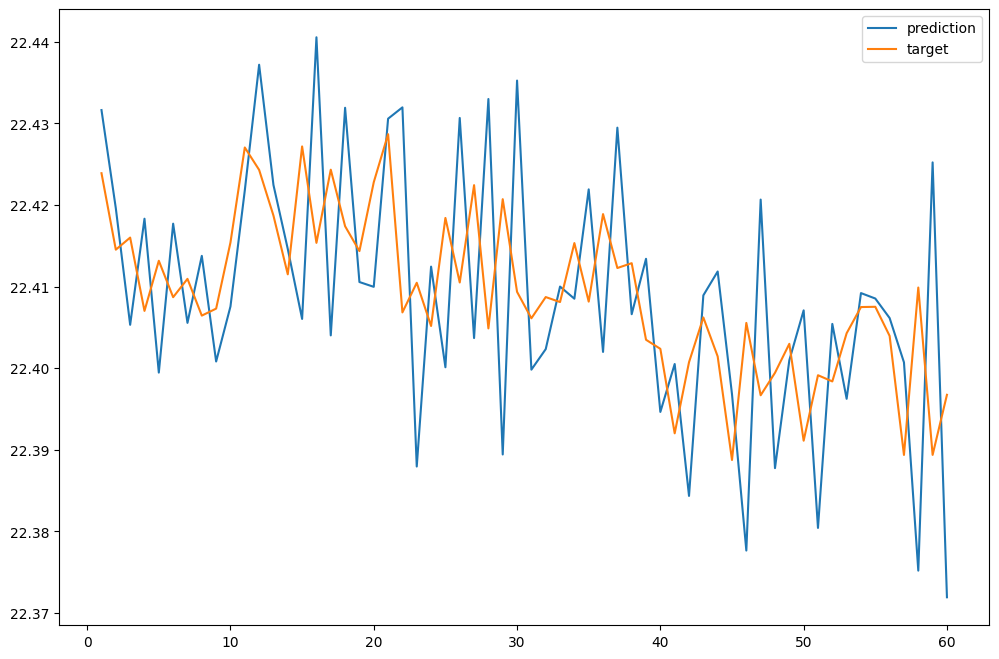

In [117]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[:60],label='prediction')
axes.plot(np.arange(1,61),target[:60],label='target')
axes.legend()

In [119]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.09563937783241272 %


In [120]:
pred_list

[22.431623458862305,
 22.419586181640625,
 22.40531349182129,
 22.418312072753906,
 22.399457931518555,
 22.41770362854004,
 22.405548095703125,
 22.41376304626465,
 22.400815963745117,
 22.40755844116211,
 22.421772003173828,
 22.437177658081055,
 22.422447204589844,
 22.414602279663086,
 22.406034469604492,
 22.440542221069336,
 22.404016494750977,
 22.43190574645996,
 22.410554885864258,
 22.40996551513672,
 22.430566787719727,
 22.431955337524414,
 22.387948989868164,
 22.41244125366211,
 22.40011215209961,
 22.4306583404541,
 22.403690338134766,
 22.432979583740234,
 22.38942527770996,
 22.435237884521484,
 22.399818420410156,
 22.402332305908203,
 22.409997940063477,
 22.408510208129883,
 22.421907424926758,
 22.40199089050293,
 22.429468154907227,
 22.406614303588867,
 22.413402557373047,
 22.394636154174805,
 22.400510787963867,
 22.384347915649414,
 22.408920288085938,
 22.411846160888672,
 22.396806716918945,
 22.377655029296875,
 22.420656204223633,
 22.38775062561035,
 22.4

In [121]:
len(target)

10080

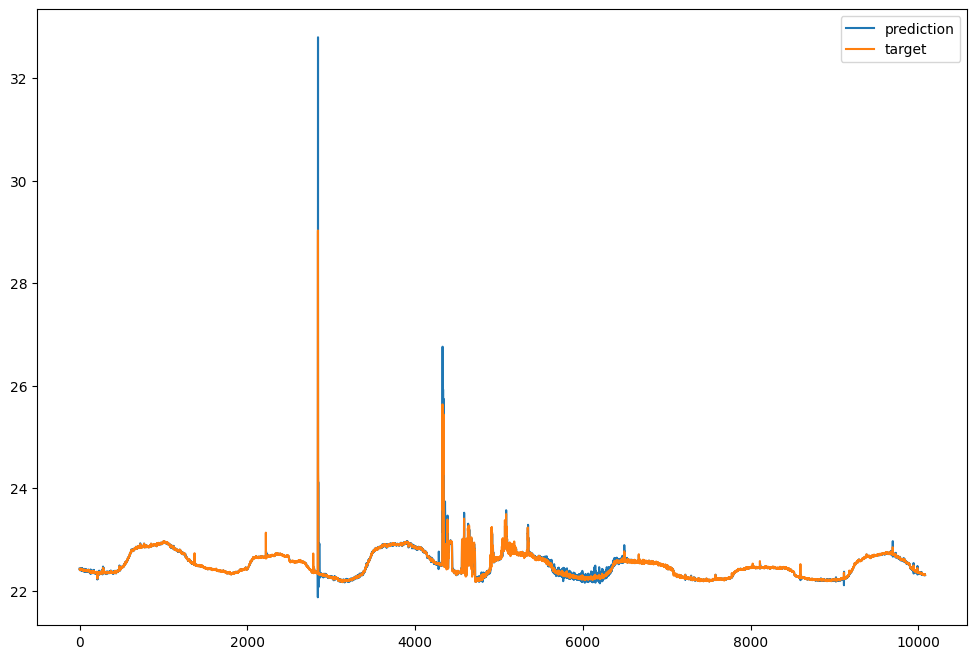

In [122]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list[:],label='prediction')
axes.plot(np.arange(1,10081),target[:],label='target')
axes.legend()

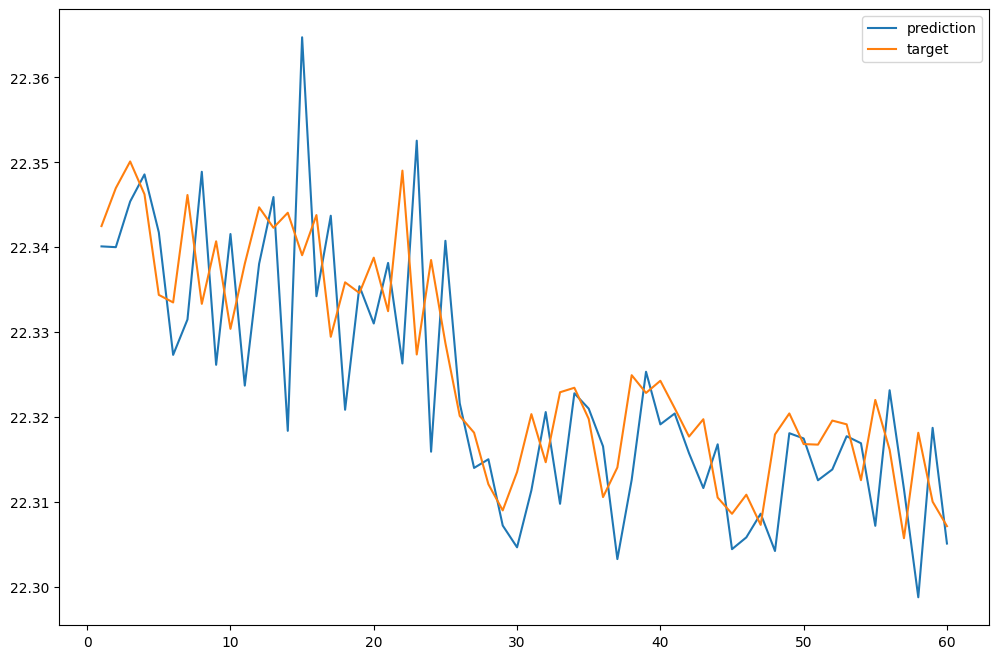

In [123]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [124]:
np.mean(time_list)

0.9908184655128963

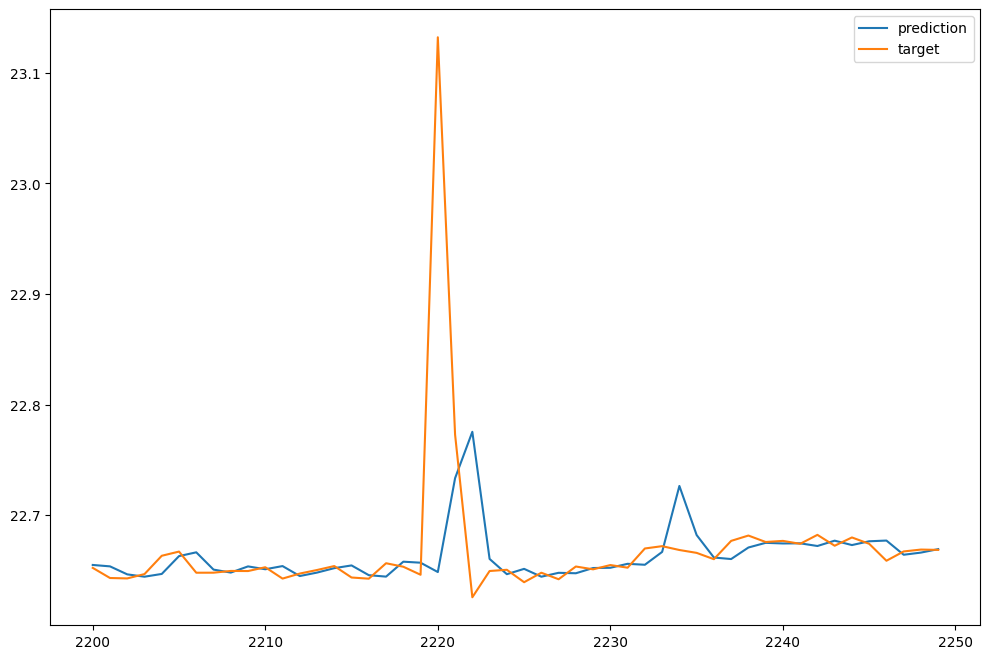

In [125]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(2200,2250),pred_list[2200:2250],label='prediction')
axes.plot(np.arange(2200,2250),target[2200:2250],label='target')
axes.legend()